# Introduction

The purpose of this notebook is to download data and process it. As a result we will get a dataset ready for further analyses and modeling.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

# let matplotlib plots be part of Jupyter Notebook
%matplotlib inline

# set up higher resolution for matplotlib plots
%config InlineBackend.figure_format = 'retina'

# Data loading and processing pipeline

In [2]:
# Change folder
%cd ../src

/Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals/src


In [3]:
# execute tests to make sure everything is working as expected
! python -m pytest

============================= test session starts ==============================
platform darwin -- Python 3.6.8, pytest-5.2.2, py-1.8.0, pluggy-0.13.0
rootdir: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski, inifile: tox.ini
collected 16 items                                                             

tests/cleaning/test_extract_gps_from_station_name.py ..                  [ 12%]
tests/cleaning/test_pipeline.py ....                                     [ 37%]
tests/cleaning/test_remove_missing_gps.py ..                             [ 50%]
tests/cleaning/test_remove_same_location.py ...                          [ 68%]
tests/features/test_holidays.py ...                                      [ 87%]
tests/features/test_season.py ..                                         [100%]

============================== 16 passed in 0.86s ==============================


In [4]:
# run data loading and processing pipeline 
# (with soft deleting so that we can inspect everything)
!python run_pipeline.py --remove=0

Pipeline execution started
Root folder set to: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals
* GpsFromStationNameExtractor *
--> input data shape:  (457015, 10)
--> output data shape:  (457015, 10)
* GpsFromStationNameExtractor *
--> input data shape:  (457015, 10)
--> output data shape:  (457015, 10)
* SameLocationRemover *
--> input data shape:  (457015, 10)
--> output data shape:  (457015, 11)
* MissingGpsLocationRemover *
--> input data shape:  (457015, 11)
--> output data shape:  (457015, 11)
* SeasonFeature *
--> input data shape:  (457015, 11)
--> output data shape:  (457015, 12)
* HolidaysFeature *
--> input data shape:  (457015, 12)
--> output data shape:  (457015, 13)
Data saved to: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals/data/processed/bike_rentals.csv
Pipeline execution completed


# Post-processing inspection

In [5]:
import os
import pandas as pd

filepath = os.path.join(os.getcwd(), '..', 'data', 'processed', 'bike_rentals.csv')

In [6]:
# load csv and set proper column types
bike_rentals_df = pd.read_csv(filepath)
bike_rentals_df['Rental datetime'] = pd.to_datetime(bike_rentals_df['Rental datetime'])
bike_rentals_df['Return datetime'] = pd.to_datetime(bike_rentals_df['Return datetime'])
bike_rentals_df['Duration'] = pd.to_timedelta(bike_rentals_df['Duration'])

In [7]:
bike_rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457015 entries, 0 to 457014
Data columns (total 13 columns):
Bike number                 457015 non-null int64
Rental datetime             457015 non-null datetime64[ns]
Return datetime             457015 non-null datetime64[ns]
Rental station              457015 non-null object
Return station              457015 non-null object
Duration                    457015 non-null timedelta64[ns]
Rental station latitude     428076 non-null float64
Rental station longitude    428076 non-null float64
Return station latitude     431411 non-null float64
Return station longitude    431411 non-null float64
IsDeleted                   457015 non-null bool
Season                      457015 non-null int64
Holidays                    457015 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(4), int64(2), object(2), timedelta64[ns](1)
memory usage: 39.2+ MB


In [8]:
# deleted records may contain NaN values
bike_rentals_df[bike_rentals_df['IsDeleted'] == True].isnull().sum()

Bike number                     0
Rental datetime                 0
Return datetime                 0
Rental station                  0
Return station                  0
Duration                        0
Rental station latitude     28939
Rental station longitude    28939
Return station latitude     25604
Return station longitude    25604
IsDeleted                       0
Season                          0
Holidays                        0
dtype: int64

In [9]:
# make sure there are no NaN values in records that are left
assert sum(bike_rentals_df[bike_rentals_df['IsDeleted'] == False].isnull().sum()) == 0

In [10]:
bike_rentals_df.head()

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays
0,57719,2019-06-26 00:00:10,2019-06-26 00:06:19,Skarbowców / Wietrzna,Krzycka / Aleja Karkonoska (Park Południowy),00:06:09,51.073290,16.994850,51.074992,17.007058,False,3,False
1,650480,2019-06-26 00:00:13,2019-06-26 00:06:59,Rynek,Plac Legionów,00:06:46,51.109782,17.030175,51.104413,17.022536,False,3,False
2,650988,2019-06-26 00:00:15,2019-06-26 00:13:32,Poza oficjalną stacją,Wałbrzyska - pętla tramwajowa,00:13:17,NaN,NaN,51.065777,16.988575,True,3,False
3,57603,2019-06-26 00:00:21,2019-06-26 00:23:53,Plac Uniwersytecki (UWr),Legnicka / Wejherowska,00:23:32,51.113871,17.034484,51.125276,16.984447,False,3,False
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False


# Visual inspection of soft deleted records

In [11]:
print(f"Number of soft deleted records: {bike_rentals_df[bike_rentals_df['IsDeleted'] == True].shape[0]}")

Number of soft deleted records: 122272


In [12]:
bike_rentals_df.loc[bike_rentals_df['Rental station latitude'].isnull(), 'Rental station'].value_counts()

Poza oficjalną stacją              28562
Pełczyńska / stacja kolejowa         193
.RELOKACYJNA A1-4                     73
Teststation IT - Adrian (VP)          28
BIKE                                  21
0, 0                                  10
plac Nankiera                          6
recording_80356921                     3
BIKE 57509                             2
.GOTOWE DO REZERWACJI                  2
Bierutowska 48                         2
Główna 1a                              1
Marii Curie-Skłodowskiej 38            1
Na Grobli 16                           1
Wiaduktowa                             1
Sucha 2                                1
Władysława Czaplińskiego 32            1
Czekoladowa 5A                         1
Na Grobli 28                           1
Krowia                                 1
Północna 15-19 2.1b                    1
Mydlana                                1
Witkowska 34a                          1
Stanisława Worcella 8                  1
Kwidzyńska 4    

In [13]:
bike_rentals_df.loc[bike_rentals_df['Return station latitude'].isnull(), 'Return station'].value_counts()

Poza oficjalną stacją              25320
Pełczyńska / stacja kolejowa         175
Teststation IT - Adrian (VP)          27
BIKE                                  15
.RELOKACYJNA A1-4                     13
0, 0                                   7
plac Nankiera                          6
recording_80356921                     3
BIKE 57509                             2
Bierutowska 48                         2
Władysława Czaplińskiego 32            1
Główna 1a                              1
Na Grobli 16                           1
Wiaduktowa                             1
Sucha 2                                1
Krowia                                 1
Czekoladowa 5A                         1
Na Grobli 28                           1
Krakowska 13                           1
Mydlana                                1
Witkowska 34a                          1
Stanisława Worcella 8                  1
Kwidzyńska 4                           1
Marii Curie-Skłodowskiej 38            1
Skarbowców 23a  

## Rentals returned to the same bike station

In [14]:
idx = (bike_rentals_df['IsDeleted'] == True) & \
      (bike_rentals_df['Rental station'] == bike_rentals_df['Return station'])
print(f"Number of records: {bike_rentals_df.loc[idx, :].shape[0]}")

Number of records: 76852


### Inspection

In [15]:
bike_rentals_df.loc[idx, :]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False
5,650020,2019-06-26 00:00:52,2019-06-26 00:01:41,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:49,51.110415,17.055591,51.110415,17.055591,True,3,False
6,650072,2019-06-26 00:01:04,2019-06-26 00:01:58,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:54,51.110415,17.055591,51.110415,17.055591,True,3,False
7,57855,2019-06-26 00:01:22,2019-06-26 00:19:56,Kościuszki / Pułaskiego,Kościuszki / Pułaskiego,00:18:34,51.100400,17.045083,51.100400,17.045083,True,3,False
9,57856,2019-06-26 00:01:57,2019-06-26 00:02:24,Kamienna / Borowska (Aquapark),Kamienna / Borowska (Aquapark),00:00:27,51.088908,17.034051,51.088908,17.034051,True,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
457009,57959,2019-10-29 23:49:00,2019-10-29 23:49:00,Kołłątaja / Podwale,Kołłątaja / Podwale,00:00:00,51.103854,17.036780,51.103854,17.036780,True,4,False
457010,650339,2019-10-29 23:50:00,2019-10-29 23:51:00,Szewska / Kazimierza Wielkiego,Szewska / Kazimierza Wielkiego,00:01:00,51.107471,17.033335,51.107471,17.033335,True,4,False
457011,650013,2019-10-29 23:51:00,2019-10-29 23:51:00,Kołłątaja / Podwale,Kołłątaja / Podwale,00:00:00,51.103854,17.036780,51.103854,17.036780,True,4,False
457012,57550,2019-10-29 23:53:00,2019-10-29 23:54:00,Rondo Reagana,Rondo Reagana,00:01:00,51.112154,17.060451,51.112154,17.060451,True,4,False


In [16]:
bike_rentals_df.loc[ (bike_rentals_df['Rental station'] == bike_rentals_df['Return station'])
                    & (bike_rentals_df['Duration'] < '00:01:00')]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays
5,650020,2019-06-26 00:00:52,2019-06-26 00:01:41,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:49,51.110415,17.055591,51.110415,17.055591,True,3,False
6,650072,2019-06-26 00:01:04,2019-06-26 00:01:58,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:54,51.110415,17.055591,51.110415,17.055591,True,3,False
9,57856,2019-06-26 00:01:57,2019-06-26 00:02:24,Kamienna / Borowska (Aquapark),Kamienna / Borowska (Aquapark),00:00:27,51.088908,17.034051,51.088908,17.034051,True,3,False
17,650544,2019-06-26 00:02:50,2019-06-26 00:03:47,Wróblewskiego (Teki),Wróblewskiego (Teki),00:00:57,51.104110,17.084711,51.104110,17.084711,True,3,False
18,650601,2019-06-26 00:03:04,2019-06-26 00:04:03,Drobnera / Dubois,Drobnera / Dubois,00:00:59,51.117032,17.033499,51.117032,17.033499,True,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
456801,57391,2019-10-29 21:46:00,2019-10-29 21:46:00,Aleja Kromera,Aleja Kromera,00:00:00,51.132259,17.065453,51.132259,17.065453,True,4,False
456950,650291,2019-10-29 22:56:00,2019-10-29 22:56:00,Plac Grunwaldzki (DS Ołówek),Plac Grunwaldzki (DS Ołówek),00:00:00,51.113912,17.067207,51.113912,17.067207,True,4,False
456979,650361,2019-10-29 23:20:00,2019-10-29 23:20:00,Rondo Reagana,Rondo Reagana,00:00:00,51.112154,17.060451,51.112154,17.060451,True,4,False
457009,57959,2019-10-29 23:49:00,2019-10-29 23:49:00,Kołłątaja / Podwale,Kołłątaja / Podwale,00:00:00,51.103854,17.036780,51.103854,17.036780,True,4,False


### Duration

In [17]:
total_seconds = bike_rentals_df.loc[idx, 'Duration'].dt.total_seconds();

print(f"Min: {total_seconds.min()}, Max: {total_seconds.max()}")
print(f"Avg: {total_seconds.mean()}, Std: {total_seconds.std()}")

Min: 0.0, Max: 56135.0
Avg: 520.872091812835, Std: 1387.2647139280132


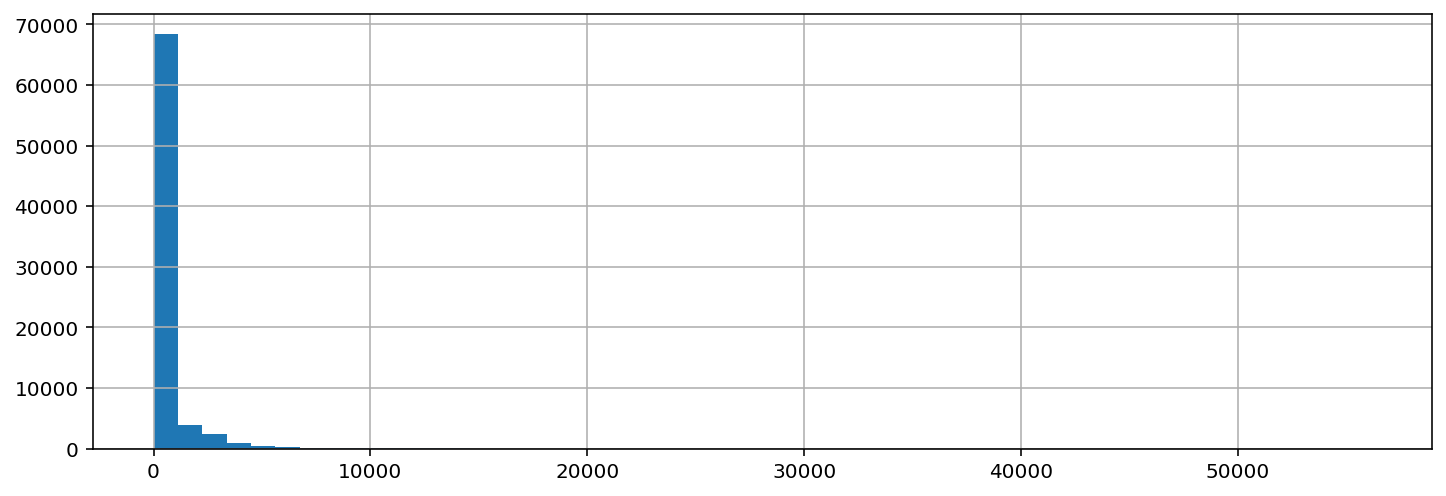

In [18]:
total_seconds.hist(bins=50, figsize=(12, 4));

### Geographical dispersion

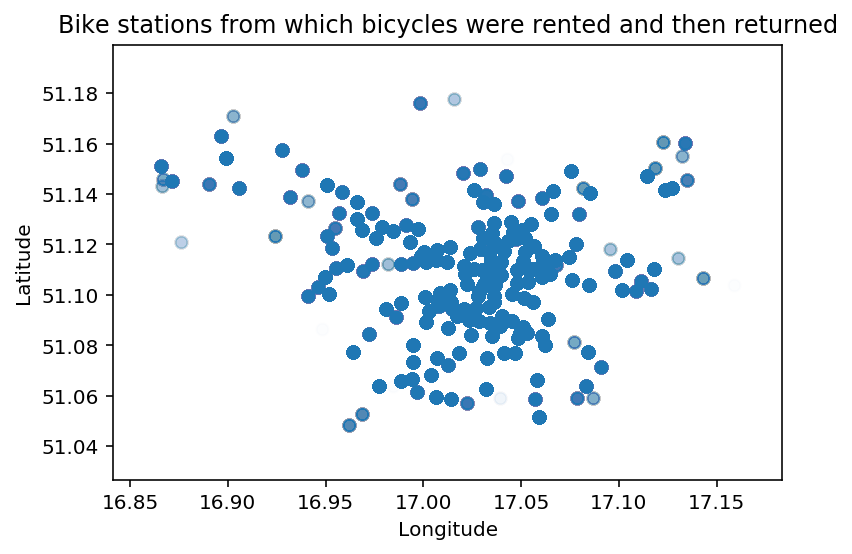

In [19]:
plt.scatter(x=bike_rentals_df.loc[idx, 'Rental station longitude'].values, 
            y=bike_rentals_df.loc[idx, 'Rental station latitude'].values, 
            alpha=0.01)
plt.title('Bike stations from which bicycles were rented and then returned')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

# Run full pipeline

In [20]:
# run data loading and processing pipeline
#!python run_pipeline.py --remove=1